In [1]:
import torch
import numpy as np
import normflows as nf

seed=42
torch.manual_seed(seed)
torch.no_grad()

import sys
import os
c_directory = os.getcwd()
sys.path.append(os.path.join(c_directory, 'BSCD'))
sys.path.append(os.path.join(c_directory, 'FCYeast'))
sys.path.append(os.path.join(c_directory, 'FCYeast3'))

from matplotlib import pyplot as plt
import FC3_simulator
import architecture

enable_cuda = True
CUDA_LAUNCH_BLOCKING=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
target = FC3_simulator.target()
context_size = 6

latent_size = 1
hidden_units = 128
hidden_layers = 5

/home/pessoa/Codes/SBIFC-inference/FCYeast3/FC3_simulator.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prior = torch.distributions.MultivariateNormal(torch.tensor(means).clone().detach().to(device), torch.diag(torch.tensor(sigmas)**2).clone().detach().to(device))
/home/pessoa/Codes/SBIFC-inference/FCYeast3/FC3_simulator.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.params_dist = torch.distributions.MultivariateNormal(torch.tensor(means).clone().detach().to(device), torch.diag(torch.tensor(sigmas)**2).clone().detach().to(device))


In [3]:
dils_str = ['12','23','33']
dils = [.12,.23,.33]
models=[]

for dil in dils_str:
    model = architecture.make_model()
    model_file = 'FCYeast3/dilution{}/FCYeast_network.pt'.format(dil)
    model.load_state_dict(torch.load(model_file))
    
    for param in model.parameters():
        param.requires_grad = False
    models.append(model)

In [4]:
import pandas as pd

dils = [.12,.23,.33]

dfs = [pd.read_csv('clean_data/complete_d={}.csv'.format(d)) for d in dils]
x = [torch.tensor(df['FL1-A'].to_numpy().astype(np.float32)).reshape(-1,1).to(device) for df in dfs]


ind = torch.arange(0,x[0].size(0),10)+seed%10
#ind = torch.arange(0,x[0].size(0),3)


x = [torch.log(xi[ind[:-1]]) for xi in x]

In [5]:
def logprior(params):
    z = (params - target.prior.loc)/ target.prior.covariance_matrix.diag()
    if torch.any(torch.abs(z)>3.01):
        return - torch.inf
    return target.prior.log_prob(params) 

vectorize_params = [torch.ones(xi.size(0),4).to(device) for xi in x]

def log_likelihood(data,params,models):
    global vectorize_params

    lp = []
    for (data_sub,params_sub,vec_params_sub,model_sub) in zip(data,params,vectorize_params,models):
        if data_sub.size !=  vec_params_sub.size(0):
            vec_params_sub = torch.ones((data_sub.size(0),4),device=device)
        lp.append(model_sub.log_prob(data_sub,params_sub*vec_params_sub))

    return lp

def log_post(data,params,models,lprior=logprior):
    return sum([lp.sum() for lp in log_likelihood(data,FC3_simulator.transform_to_arbitrary(params),models)]) + lprior(params)

In [6]:
params_100 = target.prior.sample((1000,))

best_param = target.prior.loc#params_100[-1]
lp_max = log_post(x,best_param,models)


for i in range(2,15):
    print(i)
    for par in (1/i)*(params_100-best_param) + best_param:
        lp_par = log_post(x,par,models)
        if lp_par>=lp_max:
            best_param = par
            lp_max=lp_par
            print(best_param,lp_max)


del params_100

2
tensor([10.1940,  1.0807, -0.0860, -1.1755, -0.9622,  0.3265, -1.9247, -0.4088,
         0.2640, -2.2377], device='cuda:0') tensor(-81177.5859, device='cuda:0')
tensor([10.7486, -0.0585, -0.0511, -1.8505, -0.2524, -0.6036, -1.7219, -0.3392,
         0.0986, -1.1109], device='cuda:0') tensor(-78879.0781, device='cuda:0')
tensor([10.5384,  0.2563, -0.7158, -0.4106, -0.7720, -0.0871, -1.6112,  0.1088,
         0.3259, -0.8204], device='cuda:0') tensor(-74080.1406, device='cuda:0')
tensor([11.0393,  0.2640,  0.4497, -1.9670, -0.4884,  0.0480, -1.6582, -0.5378,
         0.5191, -1.8792], device='cuda:0') tensor(-66036.8359, device='cuda:0')


KeyboardInterrupt: 

In [ ]:
param = best_param
lp = lp_max

sampled_params = [param.cpu()]
sampled_logpost = [lp.cpu().item()]

In [ ]:
S = torch.eye(10)*1e-4
mvn = torch.distributions.MultivariateNormal(torch.zeros(10,device=device),S.to(device))

def change_S(newS):
    global S
    global mvn

    S = newS
    mvn = torch.distributions.MultivariateNormal(torch.zeros(10,device=device),S.to(device))

def proposal(param):
    return param + mvn.sample()

In [ ]:
count_of_safe=0
loopruns = 0

while count_of_safe <=15:
    for i in range(150):
        param_prop = proposal(param)
        lp_prop = log_post(x,param_prop,models)

        if torch.log(torch.rand(1))< (lp_prop-lp).item():
            param = param_prop
            lp = lp_prop

        sampled_params.append(param.cpu())
        sampled_logpost.append(lp.cpu().item())

        #print(param_prop)

    acc_rate = np.mean([(sampled_params[i] - sampled_params[i-1]).sum().item()!=0 for i in range(-1,-101,-1)])

    if acc_rate>.2 and acc_rate<.5:
        count_of_safe += 1
    else:
        count_of_safe = 0

    if loopruns%3==2:
        change_S( (torch.stack(sampled_params[-200:]).T.cov() + torch.eye(10)*1e-8) * (2.4**2/(10)) )
    loopruns+=1

    print(loopruns,acc_rate, ' ', sampled_logpost[-1])#, 'priordist', (((best_param - target.prior.loc)/ target.prior.covariance_matrix.diag()).max()))
    



1 0.48   -44428.01171875
2 0.52   -43509.08984375
3 0.23   -43259.9609375
4 0.03   -43227.01953125
5 0.01   -43169.26171875
6 0.04   -43132.08203125
7 0.46   -43109.69140625
8 0.53   -43106.8359375
9 0.32   -43099.70703125
10 0.38   -43099.70703125
11 0.31   -43099.21875
12 0.51   -43100.28125
13 0.53   -43097.4296875
14 0.37   -43098.0625
15 0.38   -43096.7578125
16 0.57   -43096.86328125
17 0.38   -43096.765625
18 0.35   -43094.02734375
19 0.55   -43086.01953125
20 0.48   -43071.21875
21 0.24   -43065.390625
22 0.28   -43062.97265625
23 0.32   -43044.1875
24 0.4   -43024.20703125
25 0.41   -42933.40234375
26 0.43   -42873.6953125
27 0.48   -42825.765625
28 0.19   -42760.51171875
29 0.15   -42763.14453125
30 0.09   -42758.92578125
31 0.5   -42760.67578125
32 0.47   -42757.5859375
33 0.33   -42756.546875
34 0.48   -42756.48828125
35 0.65   -42754.71484375
36 0.56   -42752.63671875
37 0.3   -42749.10546875
38 0.47   -42753.56640625
39 0.31   -42755.5078125
40 0.18   -42751.19921875
41 0

In [ ]:
burnin = len(sampled_logpost)
for i in range(100000):
    param_prop = proposal(param)
    lp_prop = log_post(x,param_prop,models)

    if torch.log(torch.rand(1))< (lp_prop-lp).item():
        param = param_prop
        lp = lp_prop

    sampled_params.append(param.cpu().numpy())
    sampled_logpost.append(lp.cpu().item())

    if i%100 == 99:
        print(i,param,lp, logprior(param))
        np.savetxt('mcmc_real_results_{}seed.csv'.format(seed),
           np.hstack((np.stack(sampled_params), np.array(sampled_logpost).reshape(-1,1))))
        #print(i,param,lp)

99 tensor([13.4346, -0.0138,  2.9954, -4.6073, -2.0310,  1.8885, -1.8727, -3.0090,
         2.3657, -3.6487], device='cuda:0') tensor(-42581.0703, device='cuda:0') tensor(-33.6721, device='cuda:0')
199 tensor([13.4520, -0.0238,  3.0096, -4.6086, -2.0625,  1.8513, -1.9896, -3.0032,
         2.3456, -3.6253], device='cuda:0') tensor(-42583.4297, device='cuda:0') tensor(-33.6552, device='cuda:0')
299 tensor([13.3731,  0.0269,  2.9934, -4.5902, -2.0650,  1.8040, -2.2092, -3.0031,
         2.2685, -3.6722], device='cuda:0') tensor(-42586.2969, device='cuda:0') tensor(-33.4304, device='cuda:0')
399 tensor([ 1.3424e+01,  4.0996e-03,  2.9966e+00, -4.5896e+00, -2.0810e+00,
         1.8178e+00, -2.0180e+00, -3.0063e+00,  2.2651e+00, -3.5793e+00],
       device='cuda:0') tensor(-42586.1367, device='cuda:0') tensor(-33.2542, device='cuda:0')
499 tensor([13.3766,  0.0381,  2.9937, -4.5859, -2.0571,  1.8204, -2.1020, -3.0069,
         2.3116, -3.6392], device='cuda:0') tensor(-42582.6758, device='cu

KeyboardInterrupt: 

In [ ]:
np.savetxt('mcmc_real_results_{}seed.csv'.format(seed),
           np.hstack((np.stack(sampled_params), np.array(sampled_logpost).reshape(-1,1))))

NameError: name 'np' is not defined

In [ ]:
plt.plot(sampled_logpost)

NameError: name 'plt' is not defined

In [ ]:

def grid_plot(x,param,model,log10 = False):
    
    xp = torch.linspace(x.min(),x.max(),101).to(device)
    lp = model.log_prob(xp.reshape(-1,1),torch.ones((101,4),device=device)*param)
    p = torch.exp(lp-lp.max())
    p *= 1/(p.sum()*(xp[1]-xp[0]))
    if log10:
        l10 = 2.302585
        return xp.cpu()/l10,p.cpu()*l10
    return xp.cpu(),p.cpu()




In [ ]:
best_param = torch.tensor(sampled_params[np.argmax(sampled_logpost)])

In [ ]:
best_param#,np.argmax(sampled_logpost)

tensor([ 1.3410e+01,  6.6608e-03,  3.0067e+00, -4.5983e+00, -2.0904e+00,
         1.8119e+00, -1.3971e+00, -3.0098e+00,  2.3214e+00, -3.6424e+00])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


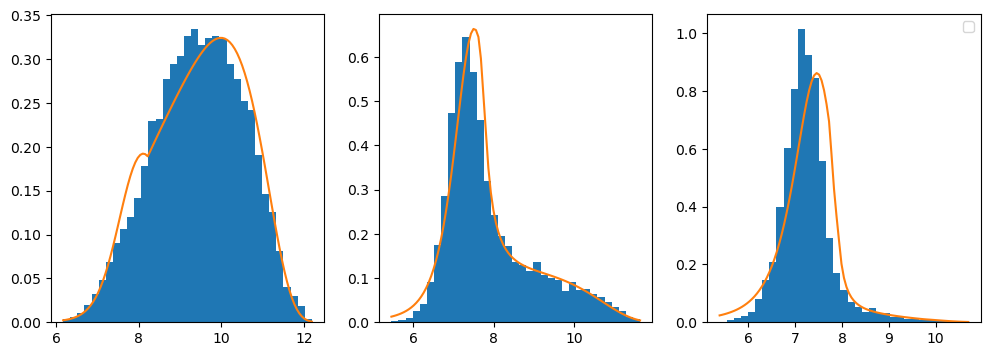

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
[axi.hist(xi.cpu().numpy().reshape(-1) ,density=True,bins=35) for (axi,xi) in zip(ax,x)]
params = FC3_simulator.transform_to_arbitrary(best_param.to(device))
[axi.plot(*grid_plot(xi,parami,model)) for (xi,parami,axi,model) in zip(x,params,ax,models)]
#[axi.hist(model.sample((10000,),parami),density=True,alpha=.4) for (xi,parami,axi,model) in zip(x,params,ax,models)]


plt.legend()

In [ ]:
import FCYeast.FCYeast_simulator 
target_after = FCYeast.FCYeast_simulator.target()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


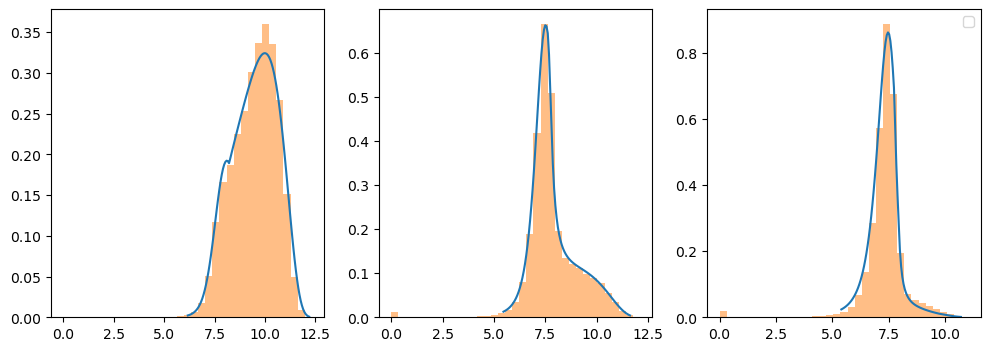

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(12,4))
#[axi.hist(xi.cpu().numpy().reshape(-1) ,density=True,bins=35) for (axi,xi) in zip(ax,x)]

params = FC3_simulator.transform_to_arbitrary(best_param.to(device))
[axi.plot(*grid_plot(xi,parami,model)) for (xi,parami,axi,model) in zip(x,params,ax,models)]

[ax[i].hist(target_after.sample(params[i,:1],params[i,1:3],params[i,3:4],n=2**16,return_lparams=False).cpu().numpy(),
          density=True,
          bins=35,alpha=.5) for i in range(3)]


plt.legend()

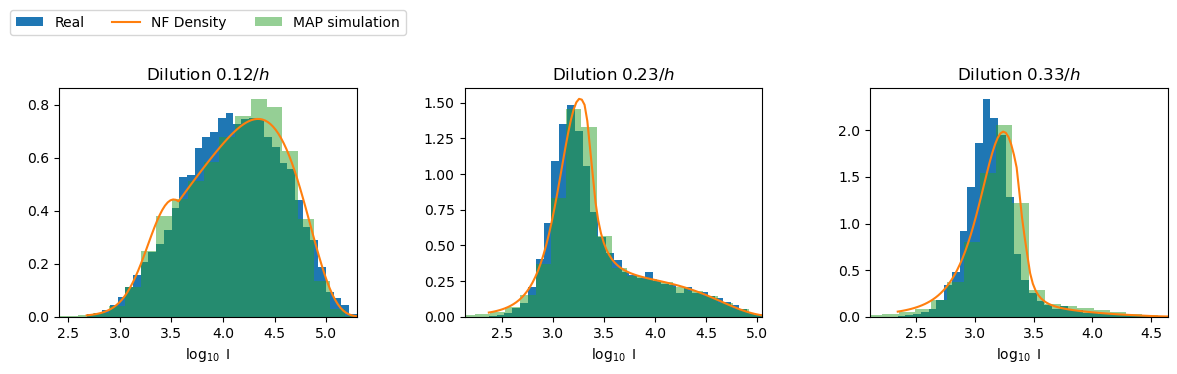

In [ ]:
l10 = 2.302585

fig,ax = plt.subplots(1,3,figsize=(12,4))
[axi.hist(xi.cpu().numpy().reshape(-1)/l10 ,density=True,bins=35,label='Real') for (axi,xi) in zip(ax,x)]
params = FC3_simulator.transform_to_arbitrary(best_param.to(device))
[axi.plot(*grid_plot(xi,parami,model,log10=True),label='NF Density') for (xi,parami,axi,model) in zip(x,params,ax,models)]
[ax[i].hist(target_after.sample(params[i,:1],params[i,1:3],params[i,3:4],n=2**16,return_lparams=False).cpu().numpy()/l10 ,
          density=True,
          bins=35,alpha=.5,label='MAP simulation')for i in range(3)]

[axi.set_xlabel(r'$\log_{10}$ I') for axi in ax]

[axi.set_title(r'Dilution {}$/h$'.format(d)) for  (axi,d) in zip(ax,[.12,.23,.33])]
[axi.set_xlim(.9*xi.cpu().min()/l10,xi.cpu().max()/l10) for  (axi,xi) in zip(ax,x)]

ax[0].legend(loc=8,ncol=3,bbox_to_anchor=(.5,1.201))
plt.tight_layout()
plt.savefig('mcmc_check_{}seed.png'.format(seed),dpi=600)


In [ ]:
x = torch.vstack(sampled_params)
torch.mean(1.0*(torch.sum(x[1:]-x[:-1],axis=1)!=0))

TypeError: expected Tensor as element 10201 in argument 0, but got numpy.ndarray

In [ ]:
dils

[0.12, 0.23, 0.33]